In [6]:
!pwd

'pwd' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


# First steps using mne


## Imports

In [20]:
# std
import os
from os import path
import time
from multiprocessing import Pool
import pickle as pkl

# 3p
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# prj
os.chdir("..")
import helpers
os.chdir('analysis-adelie')

%matplotlib qt

## Config

In [21]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, 
# the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix'
                : '/sam-AlphaTheta',
                 'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                },
                'channels_path': 'channelsList.txt'
            },
            'adelie': {
                'prefix': '/adelie-AlphaTheta',
                'recordings': {
                    'baseline': [
                        'baseline1',
                        'baseline2'
                    ],
                    'meditation': [
                        'meditation1',
                        'meditation2'
                    ]
                },
                'channels_path': 'channelsList.txt'
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'default_signal_crop': np.s_[3000:-3000], # this corresponds to ~1 second at the beginning and end, given by the sampling frequency
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [1, 4]
    }
}

## Helpers

In [22]:
def get_channelsList(config, subject='adelie'):
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    file_path = f"{base_path}/{subject_paths['prefix']}/offline/fif/{subject_paths['channels_path']}"
    with open(file_path, 'r') as channels_file:
        all_channels = channels_file.read().strip()
    return [channel for channel in all_channels.split('\n') if channel not in config['columns_to_remove']]

events = None
def load_raw_mne_from_fif(data_type, subject='adelie', recording=0, montage='standard_1020', config=cfg):
    global events
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    recording_id = helpers.get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    events = mne.find_events(raw)

    
    # Create info with some useful information
#     info = mne.create_info(['A2','P3', 'F8', 'C2'], sfreq=config['sampling_frequency'], ch_types='eeg')
#     raw.info = info
    
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=True)
    raw.set_eeg_reference('average', projection=True)#.apply_proj()
    
    return raw

def get_bandpower_parallel(df, electrodes, config=cfg):
    zipped_args = zip([df] * len(electrodes), electrodes, [config] * len(electrodes))
    with Pool(5) as p:
        all_bandpowers = p.starmap(helpers.get_bandpower_for_electrode, zipped_args)

## Base I/O


In [46]:
baseline_sam_pd = helpers.load_signal_data('baseline',  config=cfg)
meditation_sam_pd = helpers.load_signal_data('meditation', config=cfg)
baseline_adelie_pd = helpers.load_signal_data('baseline', subject='adelie', recording=1, config=cfg)
meditation_adelie_pd = helpers.load_signal_data('meditation', subject='adelie', recording=1, config=cfg)
baseline_df = baseline_adelie_pd['1min':'1min04s']
meditation_df = meditation_adelie_pd['1min':'1min04s']

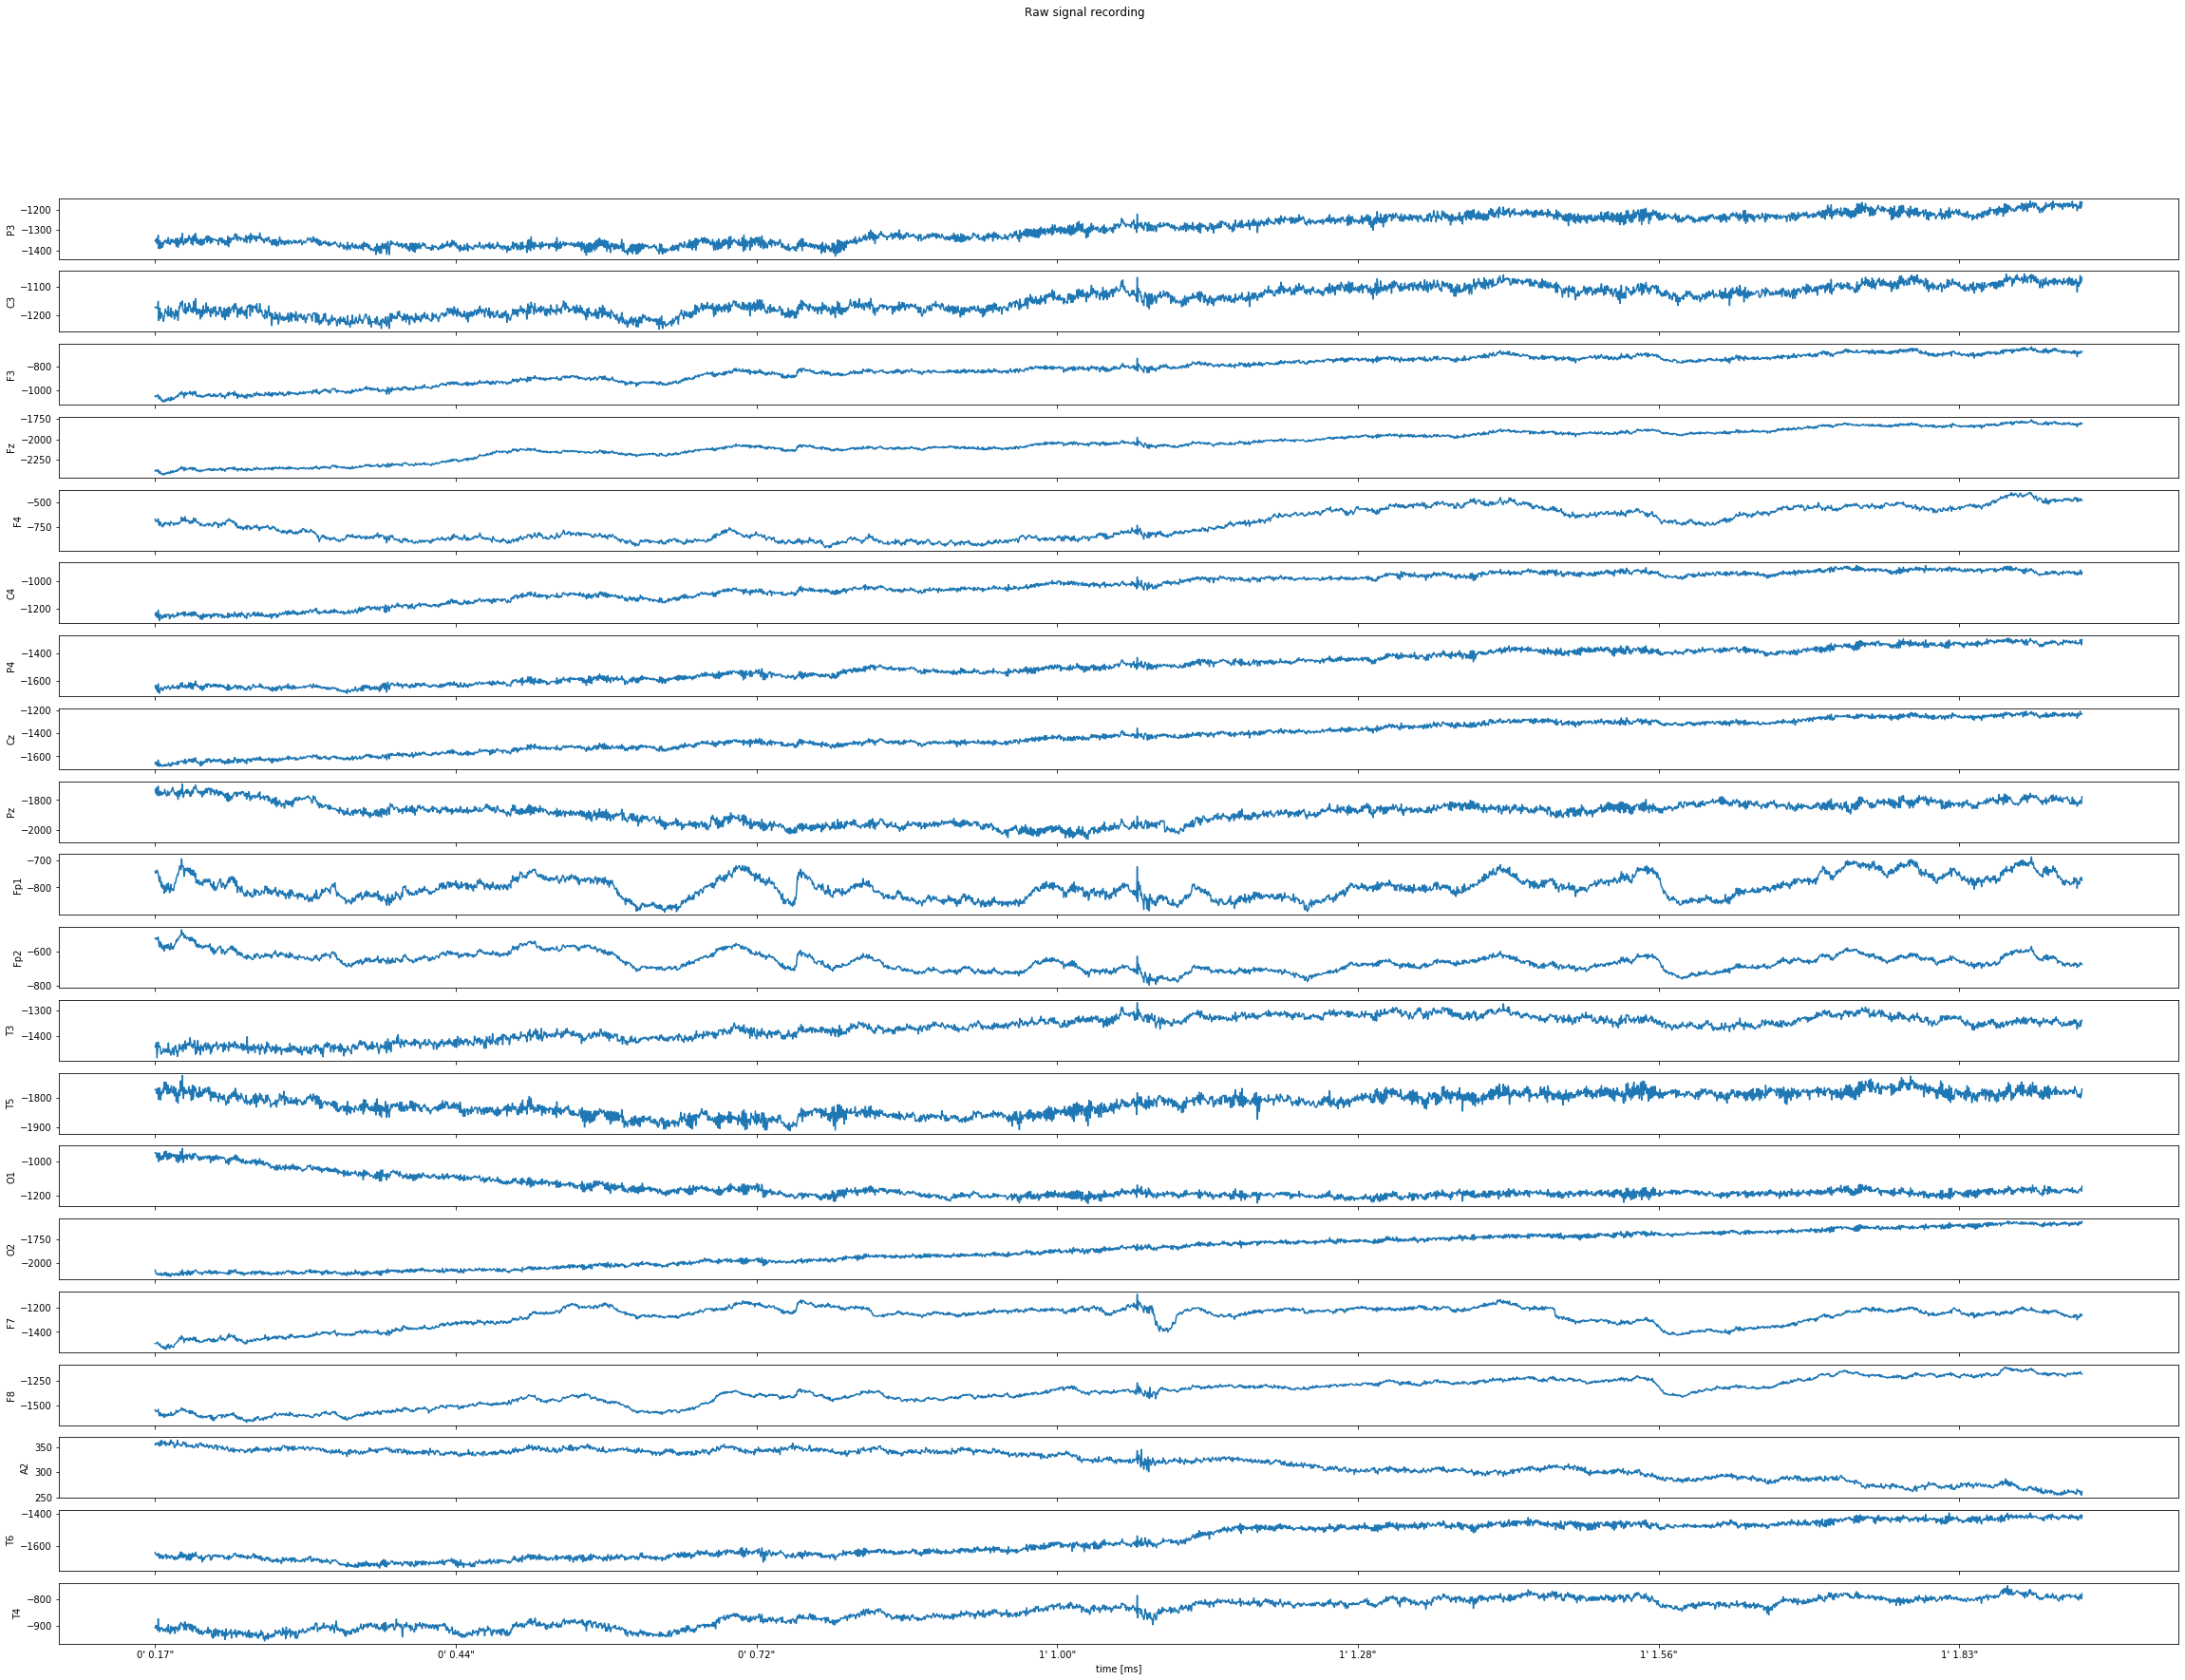

In [6]:
baseline_adelie_pd = helpers.load_signal_data('baseline', subject='adelie', recording=0, config=cfg)
meditation_adelie_pd = helpers.load_signal_data('meditation', subject='adelie', recording=0, config=cfg)
helpers.plot_raw_signal(baseline_adelie_pd);

In [51]:
def get_all_electrodes_bandpowers(baseline_df, meditation_df, electrodes, with_checkpoints=True, checkpoint_path="all_bandpowers_checkpoint_delta_1Hz.pkl", config=cfg):
    start = time.time()
    all_bandpowers = {'baseline': {}, 'meditation': {}}
    for electrode in electrodes:
        all_bandpowers['baseline'][electrode] = helpers.get_bandpower_for_electrode(baseline_df, electrode=electrode, config=config),
        if with_checkpoints:
            pkl.dump(all_bandpowers, open(checkpoint_path, "wb"))

    for electrode in electrodes:
        all_bandpowers['meditation'][electrode] = helpers.get_bandpower_for_electrode(meditation_df, electrode=electrode, config=config),
        if with_checkpoints:
            pkl.dump(all_bandpowers, open(checkpoint_path, "wb"))

    end = time.time()
    print("Took {}s to compute bandpower for all electrodes".format(end-start))
    return all_bandpowers

# electrodes_to_check = get_channelsList(cfg)
# bandpower_adelie = get_all_electrodes_bandpowers(baseline_adelie_pd, meditation_adelie_pd, electrodes_to_check)
bandpower_adelie = pkl.load(open("all_bandpowers.pkl", "rb"))

In [53]:
bandpower_adelie.keys()

dict_keys(['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Pz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'A2', 'T6', 'T4'])

In [59]:
def reorder_dict(bandpower_dict):
    bp_dict = {}
    for electrode, dfs in bandpower_adelie.items():
        for recording, bandpowers in dfs.items():
            bp_dict[recording] = {}
            bp_dict[recording][electrode] = bandpowers
    return bp_dict

def average_bandpower(bandpower_dict_ordered):
    res = {}
    for recording_name, recording in bandpower_dict_ordered.items():
        res[recording_name] = {}
        for electrode_name, bandpower in recording.items():
            for band_name, values in bandpower.items():
                if band_name in res[recording_name]:
                    res[recording_name][band_name].add(values)
                else:
                    res[recording_name][band_name] = values
        
        for band_name, values in bandpower.items():
            res[recording_name][band_name] = res[recording_name][band_name] / len(bandpower.items())
        
    return res

def epoched_average_bandpower(average_bandpower):
    res = {}
    for recording_name, average in average_bandpower.items():
        res[recording_name] = {}
        for band_name, values in average.items():
            res[recording_name][band_name] = pd.DataFrame(values).groupby([pd.Grouper(freq='10S')]).agg(['mean', 'std'])
    return res
        
bandpower_adelie_2 = reorder_dict(bandpower_adelie)
avg_bp = average_bandpower(bandpower_adelie_2)
epoched_avg_bp = epoched_average_bandpower(avg_bp)

# Bandpower by epoch

In [158]:
plt.figure()
for band, bandpower in epoched_avg_bp['baseline'].items():

    mean = bandpower.dropna()['T4']['mean']
    std = bandpower.dropna()['T4']['std']
    t = mean.reset_index().index

    plt.plot(t, mean, label=band)
    plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

plt.title("Baseline")
plt.xlabel("Epochs")
plt.ylabel("Spectral power (µV²/Hz)")  

plt.legend()
plt.show()

plt.figure()
for band, bandpower in epoched_avg_bp['meditation'].items():
    
    mean = bandpower.dropna()['T4']['mean']
    std = bandpower.dropna()['T4']['std']
    t = mean.reset_index().index

    plt.plot(t, mean, label=band)
    plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

plt.title("Meditation")
plt.xlabel("Epochs")
plt.ylabel("Mean spectral power (µV²/Hz)")    

plt.legend()
plt.show()

In [96]:
epoched_avg_bp['baseline'].keys()

dict_keys(['gamma', 'beta', 'alpha', 'theta', 'delta', 'gamma / beta', 'gamma / alpha', 'gamma / theta', 'gamma / delta', 'beta / alpha', 'beta / theta', 'beta / delta', 'alpha / theta', 'alpha / delta', 'theta / delta'])

In [159]:
plt.figure()
bandpower = epoched_avg_bp['baseline']['alpha']

mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='Alpha band')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

bandpower = epoched_avg_bp['baseline']['theta']

mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='Theta band')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

plt.title('Baseline')
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure()
bandpower = epoched_avg_bp['meditation']['alpha']
    
mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='Alpha band')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

bandpower = epoched_avg_bp['meditation']['theta']
    
mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='Theta band')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

plt.title('Meditation')
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [160]:
plt.figure()
bandpower = epoched_avg_bp['baseline']['alpha / theta']

mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='baseline')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

bandpower = epoched_avg_bp['meditation']['alpha / theta']
    
mean = bandpower.dropna()['T4']['mean']
std = bandpower.dropna()['T4']['std']
t = mean.reset_index().index

plt.plot(t, mean, label='meditation')
plt.fill_between(t, mean - std/2, mean + std/2, alpha=0.2)

plt.xlabel("Epochs")
plt.ylabel("Mean alpha/theta ratio")

plt.legend()
plt.show()

In [161]:
def aggregate_all_bandpowers(all_bandpowers):
    aggregated_fns = ['mean', 'std', 'min', 'max']
    aggregated_power = pd.DataFrame(index=pd.MultiIndex.from_product([
        list(all_bandpowers.keys()),
        list(all_bandpowers["P3"]["baseline"].keys()),
        ['baseline', 'meditation']
    ], names=["electrode", "band/ratio", "recording_type"]), columns=aggregated_fns)
    
    for electrode, dfs in all_bandpowers.items():
        baseline = dfs["baseline"]
        meditation = dfs["meditation"]
        
        for band, power in baseline.items():
            aggregated_power.loc[(electrode, band, "baseline"), :] = power['1min':'1min 30s'].agg(aggregated_fns)

        for band, power in meditation.items():
            aggregated_power.loc[(electrode, band, 'meditation'), :] = power['1min':'1min 30s'].agg(aggregated_fns)
            
        for fn in aggregated_fns:
            aggregated_power[fn] = aggregated_power[fn].astype(float)

    return aggregated_power

In [162]:
aggregated_power_adelie = aggregate_all_bandpowers(bandpower_adelie)

In [155]:
mean_bp = aggregated_power_adelie.groupby(level=[1,2]).mean()
mean_bp

mean        std       min         max
band/ratio    recording_type                                            
alpha         baseline        27.504720  15.494015  4.498742   89.427567
              meditation      12.898456   8.999087  1.875615   55.688774
alpha / delta baseline              NaN        NaN       NaN         NaN
              meditation            NaN        NaN       NaN         NaN
alpha / theta baseline         1.588977   0.836739  0.298248    8.725626
              meditation       1.431999   0.923545  0.247962    9.571993
beta          baseline         7.581855   4.702721  2.856303   35.593087
              meditation       6.594580   2.036562  2.629936   14.749256
beta / alpha  baseline         0.475826   0.434249  0.097008    3.411173
              meditation       0.860100   0.503754  0.187652    4.217906
beta / delta  baseline              NaN        NaN       NaN         NaN
              meditation            NaN        NaN       NaN         NaN
beta / theta  baseline         0.596316   0.515059  0.093353    5.855302
              meditation       0.997803   0.673233  0.164487    7.763664
delta         baseline              NaN        NaN       NaN         NaN
              meditation            NaN        NaN       NaN         NaN
gamma         baseline         8.984732  15.534626  3.201653  110.240227
              meditation       8.887678   2.944788  4.457236   24.253094
gamma / alpha baseline         0.821024   1.669447  0.096200   13.957199
              meditation       1.396963   0.955203  0.248758    7.992843
gamma / beta  baseline         1.113732   0.677033  0.451878    5.868080
              meditation       1.464236   0.456320  0.602599    3.815818
gamma / delta baseline              NaN        NaN       NaN         NaN
              meditation            NaN        NaN       NaN         NaN
gamma / theta baseline         0.887899   1.753439  0.091703   19.894560
              meditation       1.554183   1.233186  0.241929   15.613294
theta         baseline        18.647391  10.733719  2.165854   76.833329
              meditation       9.686346   5.384094  1.202171   40.542441
theta / delta baseline              NaN        NaN       NaN         NaN
              meditation            NaN        NaN       NaN         NaN

In [169]:
# bandpowers: mean 

plt.figure()
mean_bp[mean_bp.index.get_level_values(0).isin(['alpha','beta','theta','gamma','delta'])]['mean'].unstack(1).plot.bar(rot=0)

plt.ylabel("Mean spectral power (µV²/Hz)")

plt.legend()
plt.show()

In [178]:
# bandpowers: mean et std

bandList = ['alpha','beta','theta','gamma','delta']
mean_bp[mean_bp.index.get_level_values(0).isin(bandList)]['mean'].unstack(1).plot.bar(rot=0, yerr=mean_bp[mean_bp.index.get_level_values(0).isin(bandList)]['std'].unstack(1))

plt.ylabel("Mean spectral power (µV²/Hz)")

plt.title("Mean spectral band powers with bar errros during baseline vs. meditation")
plt.legend()
plt.show()

In [179]:
# ratios des bandpowers: mean et std

ratioList = ['gamma / beta', 'gamma / alpha', 'gamma / theta', 'gamma / delta', 'beta / alpha', 'beta / theta', 'beta / delta', 'alpha / theta', 'alpha / delta', 'theta / delta']
mean_bp[mean_bp.index.get_level_values(0).isin(ratioList)]['mean'].unstack(1).plot.bar(rot=0, yerr=mean_bp[mean_bp.index.get_level_values(0).isin(ratioList)]['std'].unstack(1))

plt.ylabel("Mean spectral power (µV²/Hz)")

plt.title("Mean spectral ratio powers with bar errros during baseline vs. meditation")
plt.legend()
plt.show()

In [124]:
baseline_df['avg'] = baseline_df.mean(axis=1)
meditation_df['avg'] = meditation_df.mean(axis=1)

meditation_epoched_df = meditation_df.groupby([pd.Grouper(freq='1S')]).agg(['mean', 'min', 'max', 'std'])
baseline_epoched_df = baseline_df.groupby([pd.Grouper(freq='1S')]).agg(['mean', 'min', 'max', 'std'])

C:\Users\adeli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\adeli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [126]:
from scipy.stats import ttest_ind

ttest_ind(baseline_df['avg'], meditation_df['avg'])

Ttest_indResult(statistic=464.56922647077965, pvalue=0.0)

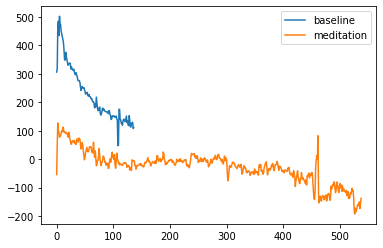

In [17]:
time = baseline_epoched_df.reset_index().index
plt.plot(time, baseline_epoched_df['avg']['mean'], label="baseline")
time = meditation_epoched_df.reset_index().index
plt.plot(time, meditation_epoched_df['avg']['mean'], label="meditation")
plt.legend()
plt.show()

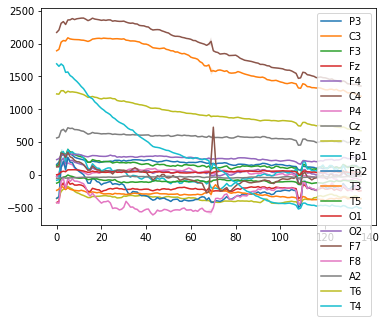

In [18]:
time = baseline_epoched_df.reset_index().index

for electrode in get_channelsList(cfg):

    mean = baseline_epoched_df[electrode]['mean']
    std = baseline_epoched_df[electrode]['std']

    plt.plot(time, mean, label=electrode)
    plt.fill_between(time, mean - std/2, mean + std/2, alpha=0.2)

plt.legend()
plt.show()

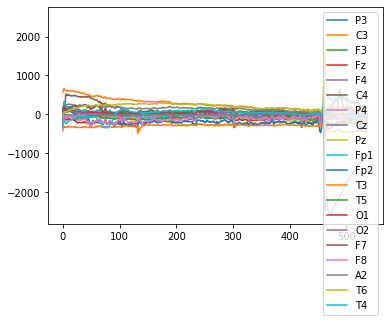

In [19]:
time = meditation_epoched_df.reset_index().index
for electrode in get_channelsList(cfg):

    mean =  meditation_epoched_df[electrode]['mean']
    std = meditation_epoched_df[electrode]['std']

    plt.plot(time, mean, label=electrode)
    plt.fill_between(time, mean - std/2, mean + std/2, alpha=0.2)

plt.legend()
plt.show()

In [139]:
helpers.get_channelsList(cfg)

KeyError: 'channels'